# Sound localisation following Dale' law

Work in progress.

In this notebook, we explore how surrogate gradient descent solves the sound localisation problem when restricted to using only excitatory or inhibitory connections.

We use the spiking solution provided in the last section of the Starting Network and we force W1 (input to hidden layer) and W2 (hidden to output layer) to be positive. We reason that this might constrain the learning to a more classical coincidence-detector strategy on the hidden layer. It is also more biologically relevant since neurons often have an excitatory or inhibitory effect on their partners but not both (known as Dale's law).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

import torch
import torch.nn as nn

!pip install tqdm
from tqdm.auto import tqdm as pbar

dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Constants
SECONDS = 1
MS = 1e-3
HZ = 1

DT = 1 * MS            # large time step to make simulations run faster
ANF_PER_EAR = 100    # repeats of each ear with independent noise

DURATION = .1 * SECONDS # stimulus duration
DURATION_STEPS = int(np.round(DURATION / DT))
INPUT_SIZE = 2 * ANF_PER_EAR

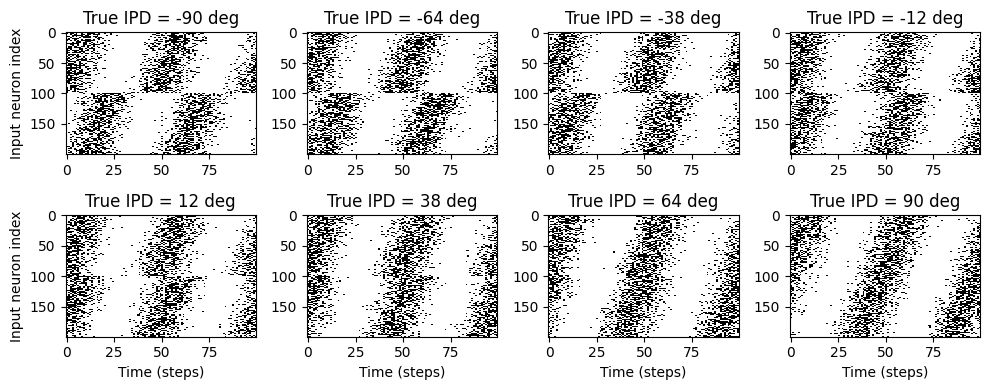

In [ ]:
def input_signal(ipd):
    """
    Generate an input signal (spike array) from array of true IPDs
    """
    envelope_power = 2   # higher values make sharper envelopes, easier
    rate_max = 600 * HZ   # maximum Poisson firing rate
    stimulus_frequency = 20 * HZ

    num_samples = len(ipd)
    times = np.arange(DURATION_STEPS) * DT # array of times
    phi = 2*np.pi*(stimulus_frequency * times + np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, DURATION_STEPS, 2*ANF_PER_EAR))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, ANF_PER_EAR)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :ANF_PER_EAR] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, ANF_PER_EAR:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, DURATION_STEPS, 2*ANF_PER_EAR)<rate_max*DT*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

def random_ipd_input_signal(num_samples, tensor=True):
    """
    Generate the training data
    Returns true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    """
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = spikes_from_fixed_idp_input_signal(ipd, tensor)

    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        

    return ipd, spikes

def spikes_from_fixed_idp_input_signal(ipd, tensor=True):
    spikes = input_signal(ipd)
    if tensor:
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return spikes

def show_examples(shown=8):
    ipd = np.linspace(-np.pi/2, np.pi/2, shown)
    spikes = spikes_from_fixed_idp_input_signal(ipd, shown)

    plt.figure(figsize=(10, 4), dpi=100)
    for i in range(shown):
        plt.subplot(2, shown // 2, i+1)
        plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
        plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
        if i>=4:
            plt.xlabel('Time (steps)')
        if i%4==0:
            plt.ylabel('Input neuron index')
    plt.tight_layout()

show_examples()

Setup training hyper parameters

In [ ]:
my_computer_is_slow = True # set this to True if using Colab

N_EPOCHS = 50

# Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
if my_computer_is_slow:
    batch_size = 64
    n_training_batches = 64
else:
    batch_size = 128
    n_training_batches = 128
n_testing_batches = 32
num_samples = batch_size*n_training_batches


In [ ]:
# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

def test_accuracy(ipds, spikes, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig)
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)

    return ipd_true, ipd_est, confusion, accs

def report_accuracy(ipd_true, ipd_est, confusion, accs, label):

    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi

    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true * 180 / np.pi, bins=NUM_CLASSES, label='True')
    plt.hist(ipd_est * 180 / np.pi, bins=NUM_CLASSES, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='equal', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    


def analyse_accuracy(ipds, spikes, run, label):
    ipd_true, ipd_est, confusion, accs = test_accuracy(ipds, spikes, run)
    report_accuracy(ipd_true, ipd_est, confusion, accs, label)
    return 100*np.mean(accs)


In [ ]:
# classes at 15 degree increments
NUM_CLASSES = 180 // 15
print(f'Number of classes = {NUM_CLASSES}')

NUM_HIDDEN = 30

def discretise(ipds):
    return ((ipds+np.pi/2) * NUM_CLASSES / np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5) / NUM_CLASSES * np.pi - np.pi / 2

Number of classes = 12


In [ ]:
def sigmoid(x, beta):
    return 1 / (1 + np.exp(-beta*x))

def sigmoid_deriv(x, beta):
    s = sigmoid(x, beta)
    return beta * s * (1 - s)


# noinspection PyAbstractClass,PyMethodOverriding
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp):
        ctx.save_for_backward(inp)
        out = torch.zeros_like(inp)
        out[inp > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        inp, = ctx.saved_tensors
        sigmoid_derivative = sigmoid_deriv(inp, beta=5)
        grad = grad_output*sigmoid_derivative
        return grad

spike_fn  = SurrGradSpike.apply


def membrane_only(input_spikes, weights, tau=20 * MS):
    """
    :param input_spikes: has shape (batch_size, duration_steps, input_size)
    :param weights: has shape  (input_size, num_classes
    :param tau: 
    :return: 
    """
    
    batch_size = input_spikes.shape[0]
    assert len(input_spikes.shape) == 3
    
    v = torch.zeros((batch_size, NUM_CLASSES), device=device, dtype=dtype)
    # v_rec will store the membrane in each time step
    v_rec = [v]
    # Batch matrix multiplication all time steps
    # Equivalent to matrix multiply input_spikes[b, :, :] x W for all b, but faster
    h = torch.einsum("abc,cd->abd", (input_spikes, weights))
    ##################### MISSING CODE #####################################
    # precalculate multiplication factor, what should this be?
    alpha = np.exp(-DT / tau)
    # Update membrane and spikes one time step at a time
    for t in range(DURATION_STEPS - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    # return the recorded membrane potentials stacked into a single tensor
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec


In [ ]:
# noinspection PyProtectedMember
def init_weight_matrices(inhib_chance = 0.1):
    """Weights and uniform weight initialisation"""

    # Input to hidden layer
    w1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w1, -bound, bound)

    # Hidden layer to output
    w2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w2, -bound, bound)

    #Get fixed signs for the weight, 90% excitatory 
    signs = [(torch.rand_like(w) > inhib_chance).float() for w in (w1, w2)]
    
    for s in signs : 
      s[s == 0] = -1
      s.requires_grad=False

    return w1, w2, signs


def get_signed_weights(w, sign):
    """Get the signed value of the weight"""
    # Note abs is in principle not differentiable.
    # In practice, pytorch will set the derivative to 0 when the values are 0.
    # (see https://discuss.pytorch.org/t/how-does-autograd-deal-with-non-differentiable-opponents-such-as-abs-and-max/34538)
    # This has the adverse effect that, during training, if a synapse reaches 0,
    # it is "culled" and can not be recovered.
    # It should be possible to cheat here and either "wiggle" 0-valued synapses,
    # or to override abs gradient to return a very small random number.

    #TODO try ReLu or other activation
    #TODO reproduce paper https://www.biorxiv.org/content/10.1101/2020.11.02.364968v2.full

   # return torch.max(w, 0)*sign
    return torch.abs(w)*sign

def layer1(input_spikes, w1, tau, sign1):

    w1 = get_signed_weights(w1, sign1)

    batch_size = input_spikes.shape[0]

    # First layer: input to hidden
    v = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s = torch.zeros((batch_size, NUM_HIDDEN), device=device, dtype=dtype)
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, w1))
    alpha = np.exp(-DT / tau)
    for t in range(DURATION_STEPS - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        s_rec.append(s)
    s_rec = torch.stack(s_rec, dim=1)
    
    return s_rec

def layer2(s_rec, w2, tau, sign2):
    """Second layer: hidden to output"""
    w2 = get_signed_weights(w2, sign2)

    v_rec = membrane_only(s_rec, w2, tau=tau)
    return v_rec


def snn(input_spikes, w1, w2, signs, tau=20 * MS):
    """Run the simulation"""
        
    s_rec = layer1(input_spikes, w1, tau, signs[0])
    v_rec = layer2(s_rec, w2, tau, signs[1])

    # Return recorded membrane potential of output
    return v_rec

In [ ]:
w1, w2, signs = init_weight_matrices()

In [ ]:
(signs[1] == 1).float().mean()

tensor(0.9028)

In [ ]:
def train(ipds, spikes, ipds_validation, spikes_validation, lr=0.01):
    """
    :param lr: learning rate
    :return:
    """
    # Initialise a weight matrices
    w1, w2, signs = init_weight_matrices()

    ####################### MISSING CODE BELOW ########################
    # You need to learn parameters for two matrices
    # Optimiser and loss function
    optimizer = torch.optim.Adam([w1, w2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    print(f"Want loss for epoch 1 to be about {-np.log(1 / NUM_CLASSES):.2f}, multiply m by constant to get this")

    loss_hist = []
    val_loss_hist = []

    best_loss = 1e10
    val_loss_best_loss = 1e10

    for e in pbar(range(N_EPOCHS)):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            #reg = torch.abs(torch.clamp(torch.min(W1), -np.inf, 0)) * 100
            reg = 0

            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))

        val_local_loss = []
        for x_local, y_local in data_generator(discretise(ipds_validation), spikes_validation):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            val_loss = loss_fn(log_softmax_fn(m), y_local) 
            val_local_loss.append(val_loss.item())

        val_loss_hist.append(np.mean(val_local_loss))

        if np.mean(val_local_loss) < val_loss_best_loss:
            val_loss_best_loss = np.mean(val_local_loss)
            best_weights = get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs


        # noinspection PyStringFormat
        print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        print("Epoch %i: val_loss=%.5f"%(e+1, np.mean(val_local_loss)))

        #Early Stopping : 
        if torch.tensor(val_loss_hist[-5:]).argmin() == 0  and e>5: 
          print('Early Stop !')
          return best_weights

    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.plot(val_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    return get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs

# Generate the training data
ipds_training, spikes_training = random_ipd_input_signal(num_samples)
ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)


w1_trained, w2_trained, signs = train(ipds_training, spikes_training, ipds_validation, spikes_validation)



Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.45160
Epoch 1: val_loss=1.75582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 2: loss=1.60309
Epoch 2: val_loss=1.59292
Epoch 3: loss=1.38979
Epoch 3: val_loss=1.31655
Epoch 4: loss=1.26190
Epoch 4: val_loss=1.32020
Epoch 5: loss=1.14710
Epoch 5: val_loss=1.14961
Epoch 6: loss=1.04391
Epoch 6: val_loss=1.08271
Epoch 7: loss=0.99179
Epoch 7: val_loss=1.03300
Epoch 8: loss=0.98086
Epoch 8: val_loss=1.03807
Epoch 9: loss=0.90790
Epoch 9: val_loss=0.96943
Epoch 10: loss=0.87957
Epoch 10: val_loss=0.96627
Epoch 11: loss=0.86149
Epoch 11: val_loss=0.93606
Epoch 12: loss=0.83661
Epoch 12: val_loss=0.91211
Epoch 13: loss=0.79214
Epoch 13: val_loss=0.93772
Epoch 14: loss=0.79484
Epoch 14: val_loss=0.90903
Epoch 15: loss=0.78324
Epoch 15: val_loss=0.87302
Epoch 16: loss=0.74987
Epoch 16: val_loss=0.89056
Epoch 17: loss=0.71573
Epoch 17: val_loss=0.79258
Epoch 18: loss=0.69503
Epoch 18: val_loss=1.00494
Epoch 19: loss=0.71391
Epoch 19: val_loss=0.76984
Epoch 20: loss=0.70055
Epoch 20: val_loss=0.80496
Epoch 21: loss=0.66087
Epoch 21: val_loss=0.92770
Epoch 22: loss=0

In [ ]:
loss_hist

NameError: ignored

In [ ]:
assert torch.max(w1_trained[signs[0] == -1]) < 0
assert torch.max(w2_trained[signs[1] == -1]) < 0

Chance accuracy level: 8.3%

Train classifier accuracy: 81.5%
Train absolute error: 5.0 deg

Test classifier accuracy: 71.2%
Test absolute error: 5.8 deg


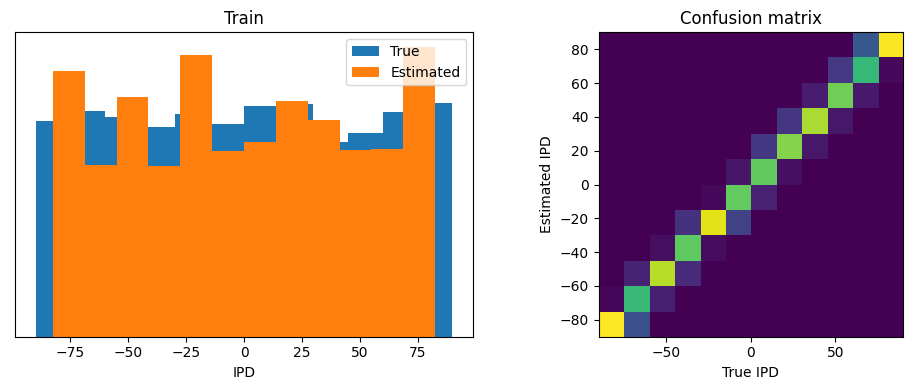

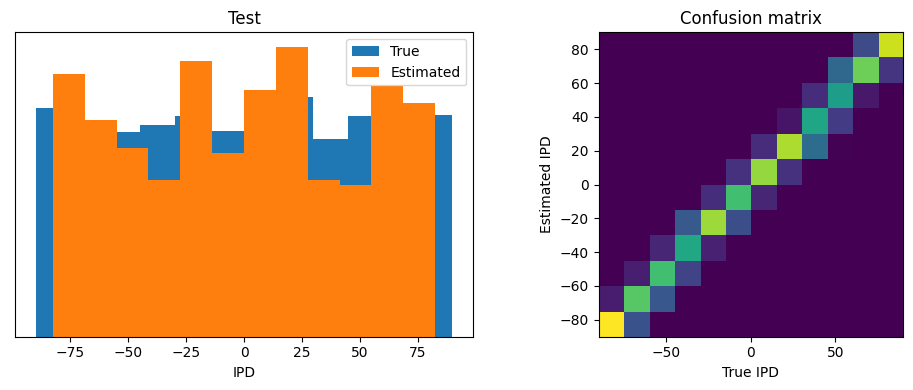

In [ ]:
# Analyse
print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
run_func = lambda x: snn(x, w1_trained, w2_trained, signs)
analyse_accuracy(ipds_training, spikes_training, run_func, 'Train')

ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse_accuracy(ipds_test, spikes_test, run_func, 'Test')

Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.32383
Epoch 1: val_loss=1.83923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 2: loss=1.58033
Epoch 2: val_loss=1.60969
Epoch 3: loss=1.37485
Epoch 3: val_loss=1.45469
Epoch 4: loss=1.23552
Epoch 4: val_loss=1.40714
Epoch 5: loss=1.12968
Epoch 5: val_loss=1.44195
Epoch 6: loss=1.08965
Epoch 6: val_loss=1.24560
Epoch 7: loss=0.98850
Epoch 7: val_loss=1.17588
Epoch 8: loss=0.95648
Epoch 8: val_loss=1.14515
Epoch 9: loss=0.93911
Epoch 9: val_loss=1.15681
Epoch 10: loss=0.88180
Epoch 10: val_loss=1.13883
Epoch 11: loss=0.84614
Epoch 11: val_loss=1.02746
Epoch 12: loss=0.81782
Epoch 12: val_loss=1.22521
Epoch 13: loss=0.79602
Epoch 13: val_loss=0.99110
Epoch 14: loss=0.77118
Epoch 14: val_loss=1.07433
Epoch 15: loss=0.75480
Epoch 15: val_loss=0.99758
Epoch 16: loss=0.72674
Epoch 16: val_loss=1.12289
Epoch 17: loss=0.72402
Epoch 17: val_loss=0.94172
Epoch 18: loss=0.70763
Epoch 18: val_loss=0.89095
Epoch 19: loss=0.71368
Epoch 19: val_loss=1.22109
Epoch 20: loss=0.73130
Epoch 20: val_loss=0.95658
Epoch 21: loss=0.70152
Epoch 21: val_loss=1.03324
Epoch 22: loss=0

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.18469
Epoch 1: val_loss=1.80430
Epoch 2: loss=1.59778
Epoch 2: val_loss=1.68441
Epoch 3: loss=1.39172
Epoch 3: val_loss=1.47725
Epoch 4: loss=1.27560
Epoch 4: val_loss=1.52343
Epoch 5: loss=1.16718
Epoch 5: val_loss=1.39909
Epoch 6: loss=1.08792
Epoch 6: val_loss=1.30133
Epoch 7: loss=1.03043
Epoch 7: val_loss=1.25315
Epoch 8: loss=1.00496
Epoch 8: val_loss=1.19662
Epoch 9: loss=0.96631
Epoch 9: val_loss=1.35709
Epoch 10: loss=0.94079
Epoch 10: val_loss=1.15007
Epoch 11: loss=0.88974
Epoch 11: val_loss=1.06937
Epoch 12: loss=0.86900
Epoch 12: val_loss=1.08042
Epoch 13: loss=0.84516
Epoch 13: val_loss=1.10884
Epoch 14: loss=0.80554
Epoch 14: val_loss=1.04891
Epoch 15: loss=0.80565
Epoch 15: val_loss=1.04808
Epoch 16: loss=0.77290
Epoch 16: val_loss=1.01911
Epoch 17: loss=0.79229
Epoch 17: val_loss=0.96662
Epoch 18: loss=0.75452
Epoch 18: val_loss=1.02399
Epoch 19: loss=0.72938
Epoch 19: val_loss=1.03382
Epoch 20: loss=0.69511
Epoch 20: val_loss=0.99946
Epoch 21: loss=0.7

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.31732
Epoch 1: val_loss=1.92572
Epoch 2: loss=1.53800
Epoch 2: val_loss=1.53640
Epoch 3: loss=1.33558
Epoch 3: val_loss=1.48808
Epoch 4: loss=1.19339
Epoch 4: val_loss=1.38677
Epoch 5: loss=1.13032
Epoch 5: val_loss=1.32889
Epoch 6: loss=1.05563
Epoch 6: val_loss=1.43737
Epoch 7: loss=0.99680
Epoch 7: val_loss=1.24341
Epoch 8: loss=0.99797
Epoch 8: val_loss=1.16495
Epoch 9: loss=0.91942
Epoch 9: val_loss=1.12776
Epoch 10: loss=0.88892
Epoch 10: val_loss=1.08980
Epoch 11: loss=0.85673
Epoch 11: val_loss=1.02183
Epoch 12: loss=0.84667
Epoch 12: val_loss=1.11181
Epoch 13: loss=0.82319
Epoch 13: val_loss=1.02525
Epoch 14: loss=0.82416
Epoch 14: val_loss=1.07900
Epoch 15: loss=0.78888
Epoch 15: val_loss=1.05506
Early Stop !

Train classifier accuracy: 69.0%
Train absolute error: 6.1 deg

Test classifier accuracy: 59.5%
Test absolute error: 7.2 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.48382
Epoch 1: val_loss=1.78196
Epoch 2: loss=1.61233
Epoch 2: val_loss=1.54569
Epoch 3: loss=1.41284
Epoch 3: val_loss=1.57238
Epoch 4: loss=1.26034
Epoch 4: val_loss=1.36126
Epoch 5: loss=1.14243
Epoch 5: val_loss=1.29258
Epoch 6: loss=1.07944
Epoch 6: val_loss=1.22268
Epoch 7: loss=1.01269
Epoch 7: val_loss=1.27669
Epoch 8: loss=0.96312
Epoch 8: val_loss=1.13975
Epoch 9: loss=0.94487
Epoch 9: val_loss=1.22333
Epoch 10: loss=0.91903
Epoch 10: val_loss=1.17375
Epoch 11: loss=0.89206
Epoch 11: val_loss=1.11811
Epoch 12: loss=0.84308
Epoch 12: val_loss=1.28549
Epoch 13: loss=0.85684
Epoch 13: val_loss=1.12784
Epoch 14: loss=0.80808
Epoch 14: val_loss=1.18693
Epoch 15: loss=0.78951
Epoch 15: val_loss=1.28390
Early Stop !

Train classifier accuracy: 63.3%
Train absolute error: 6.8 deg

Test classifier accuracy: 54.2%
Test absolute error: 8.0 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.38532
Epoch 1: val_loss=1.83016
Epoch 2: loss=1.59686
Epoch 2: val_loss=1.60188
Epoch 3: loss=1.38907
Epoch 3: val_loss=1.46105
Epoch 4: loss=1.24346
Epoch 4: val_loss=1.39038
Epoch 5: loss=1.17298
Epoch 5: val_loss=1.30614
Epoch 6: loss=1.07873
Epoch 6: val_loss=1.31279
Epoch 7: loss=1.01861
Epoch 7: val_loss=1.20694
Epoch 8: loss=0.98948
Epoch 8: val_loss=1.31688
Epoch 9: loss=0.96612
Epoch 9: val_loss=1.17905
Epoch 10: loss=0.91059
Epoch 10: val_loss=1.08945
Epoch 11: loss=0.89059
Epoch 11: val_loss=1.10841
Epoch 12: loss=0.86687
Epoch 12: val_loss=1.15619
Epoch 13: loss=0.81380
Epoch 13: val_loss=1.13286
Epoch 14: loss=0.79368
Epoch 14: val_loss=1.02552
Epoch 15: loss=0.78831
Epoch 15: val_loss=0.99966
Epoch 16: loss=0.78496
Epoch 16: val_loss=1.00417
Epoch 17: loss=0.75363
Epoch 17: val_loss=0.92109
Epoch 18: loss=0.74898
Epoch 18: val_loss=0.91926
Epoch 19: loss=0.72472
Epoch 19: val_loss=0.94949
Epoch 20: loss=0.72298
Epoch 20: val_loss=0.94213
Epoch 21: loss=0.7

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.44165
Epoch 1: val_loss=1.83963
Epoch 2: loss=1.59123
Epoch 2: val_loss=1.72383
Epoch 3: loss=1.38439
Epoch 3: val_loss=1.37713
Epoch 4: loss=1.21056
Epoch 4: val_loss=1.33605
Epoch 5: loss=1.12064
Epoch 5: val_loss=1.26706
Epoch 6: loss=1.08076
Epoch 6: val_loss=1.21253
Epoch 7: loss=1.00299
Epoch 7: val_loss=1.16498
Epoch 8: loss=0.96358
Epoch 8: val_loss=1.16091
Epoch 9: loss=0.95767
Epoch 9: val_loss=1.10795
Epoch 10: loss=0.88664
Epoch 10: val_loss=1.16682
Epoch 11: loss=0.85384
Epoch 11: val_loss=1.04018
Epoch 12: loss=0.84255
Epoch 12: val_loss=1.07733
Epoch 13: loss=0.79668
Epoch 13: val_loss=1.07597
Epoch 14: loss=0.78778
Epoch 14: val_loss=1.05453
Epoch 15: loss=0.76467
Epoch 15: val_loss=1.04748
Early Stop !

Train classifier accuracy: 69.8%
Train absolute error: 6.1 deg

Test classifier accuracy: 62.3%
Test absolute error: 7.0 deg
Want loss for epoch 1 to be about 2.48, multiply m by constant to get this


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.27270
Epoch 1: val_loss=1.81264
Epoch 2: loss=1.53751
Epoch 2: val_loss=1.64727
Epoch 3: loss=1.33711
Epoch 3: val_loss=1.39494
Epoch 4: loss=1.23498
Epoch 4: val_loss=1.45194
Epoch 5: loss=1.19639
Epoch 5: val_loss=1.41695
Epoch 6: loss=1.08029
Epoch 6: val_loss=1.16916
Epoch 7: loss=1.00567
Epoch 7: val_loss=1.20786
Epoch 8: loss=0.98267
Epoch 8: val_loss=1.15124
Epoch 9: loss=0.91535
Epoch 9: val_loss=1.09134
Epoch 10: loss=0.88662
Epoch 10: val_loss=1.13420
Epoch 11: loss=0.87437
Epoch 11: val_loss=1.05763
Epoch 12: loss=0.88724
Epoch 12: val_loss=1.27448
Epoch 13: loss=0.82034
Epoch 13: val_loss=0.99914
Epoch 14: loss=0.78151
Epoch 14: val_loss=1.01816
Epoch 15: loss=0.77874
Epoch 15: val_loss=0.97393
Epoch 16: loss=0.77544
Epoch 16: val_loss=0.96800
Epoch 17: loss=0.76776
Epoch 17: val_loss=0.90890
Epoch 18: loss=0.74044
Epoch 18: val_loss=1.01833
Epoch 19: loss=0.76219
Epoch 19: val_loss=0.94001
Epoch 20: loss=0.69928
Epoch 20: val_loss=0.99949
Epoch 21: loss=0.6

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.26747
Epoch 1: val_loss=1.78734
Epoch 2: loss=1.59504
Epoch 2: val_loss=1.53764
Epoch 3: loss=1.37862
Epoch 3: val_loss=1.48290
Epoch 4: loss=1.24281
Epoch 4: val_loss=1.38991
Epoch 5: loss=1.18824
Epoch 5: val_loss=1.17560
Epoch 6: loss=1.06745
Epoch 6: val_loss=1.20258
Epoch 7: loss=1.04792
Epoch 7: val_loss=1.14801
Epoch 8: loss=0.95641
Epoch 8: val_loss=1.13501
Epoch 9: loss=0.91089
Epoch 9: val_loss=1.06432
Epoch 10: loss=0.85777
Epoch 10: val_loss=1.15179
Epoch 11: loss=0.89088
Epoch 11: val_loss=1.15360
Epoch 12: loss=0.88252
Epoch 12: val_loss=1.04038
Epoch 13: loss=0.80750
Epoch 13: val_loss=1.05179
Epoch 14: loss=0.78546
Epoch 14: val_loss=1.03681
Epoch 15: loss=0.76862
Epoch 15: val_loss=0.95611
Epoch 16: loss=0.74843
Epoch 16: val_loss=0.97024
Epoch 17: loss=0.73396
Epoch 17: val_loss=0.90929
Epoch 18: loss=0.71315
Epoch 18: val_loss=0.99314
Epoch 19: loss=0.69355
Epoch 19: val_loss=0.86876
Epoch 20: loss=0.69913
Epoch 20: val_loss=0.93685
Epoch 21: loss=0.6

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.18766
Epoch 1: val_loss=1.83476
Epoch 2: loss=1.48883
Epoch 2: val_loss=1.65568
Epoch 3: loss=1.29887
Epoch 3: val_loss=1.42888
Epoch 4: loss=1.16542
Epoch 4: val_loss=1.34483
Epoch 5: loss=1.10830
Epoch 5: val_loss=1.19314
Epoch 6: loss=1.04386
Epoch 6: val_loss=1.35090
Epoch 7: loss=0.99860
Epoch 7: val_loss=1.21527
Epoch 8: loss=0.96372
Epoch 8: val_loss=1.13533
Epoch 9: loss=0.92965
Epoch 9: val_loss=1.16387
Epoch 10: loss=0.90111
Epoch 10: val_loss=1.06629
Epoch 11: loss=0.86929
Epoch 11: val_loss=1.12762
Epoch 12: loss=0.84614
Epoch 12: val_loss=1.02672
Epoch 13: loss=0.80918
Epoch 13: val_loss=0.93681
Epoch 14: loss=0.78921
Epoch 14: val_loss=1.04302
Epoch 15: loss=0.76463
Epoch 15: val_loss=0.95561
Epoch 16: loss=0.73311
Epoch 16: val_loss=0.98057
Epoch 17: loss=0.74023
Epoch 17: val_loss=0.90737
Epoch 18: loss=0.71704
Epoch 18: val_loss=1.01202
Epoch 19: loss=0.70132
Epoch 19: val_loss=0.93532
Epoch 20: loss=0.69472
Epoch 20: val_loss=0.95004
Epoch 21: loss=0.6

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.41833
Epoch 1: val_loss=1.84040
Epoch 2: loss=1.52300
Epoch 2: val_loss=1.61792
Epoch 3: loss=1.34754
Epoch 3: val_loss=1.45204
Epoch 4: loss=1.19636
Epoch 4: val_loss=1.41759
Epoch 5: loss=1.11955
Epoch 5: val_loss=1.31152
Epoch 6: loss=1.08740
Epoch 6: val_loss=1.27064
Epoch 7: loss=1.02270
Epoch 7: val_loss=1.14898
Epoch 8: loss=0.99396
Epoch 8: val_loss=1.15997
Epoch 9: loss=0.96526
Epoch 9: val_loss=1.24990
Epoch 10: loss=0.89942
Epoch 10: val_loss=1.10099
Epoch 11: loss=0.88919
Epoch 11: val_loss=1.06369
Epoch 12: loss=0.86435
Epoch 12: val_loss=1.02753
Epoch 13: loss=0.83323
Epoch 13: val_loss=1.04797
Epoch 14: loss=0.80460
Epoch 14: val_loss=0.95901
Epoch 15: loss=0.79244
Epoch 15: val_loss=0.96287
Epoch 16: loss=0.77950
Epoch 16: val_loss=0.96806
Epoch 17: loss=0.80479
Epoch 17: val_loss=1.01067
Epoch 18: loss=0.76218
Epoch 18: val_loss=1.04682
Early Stop !

Train classifier accuracy: 73.4%
Train absolute error: 5.7 deg

Test classifier accuracy: 59.0%
Test abs

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: loss=2.28007
Epoch 1: val_loss=1.84200
Epoch 2: loss=1.52336
Epoch 2: val_loss=1.53510
Epoch 3: loss=1.32637
Epoch 3: val_loss=1.56237
Epoch 4: loss=1.22903
Epoch 4: val_loss=1.41510
Epoch 5: loss=1.13919
Epoch 5: val_loss=1.28183
Epoch 6: loss=1.08644
Epoch 6: val_loss=1.28955
Epoch 7: loss=1.04012
Epoch 7: val_loss=1.14526
Epoch 8: loss=0.99668
Epoch 8: val_loss=1.16941
Epoch 9: loss=0.95582
Epoch 9: val_loss=1.30538
Epoch 10: loss=0.91743
Epoch 10: val_loss=1.27879
Epoch 11: loss=0.89265
Epoch 11: val_loss=1.19913
Early Stop !

Train classifier accuracy: 67.4%
Train absolute error: 6.7 deg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Test classifier accuracy: 54.8%
Test absolute error: 8.5 deg


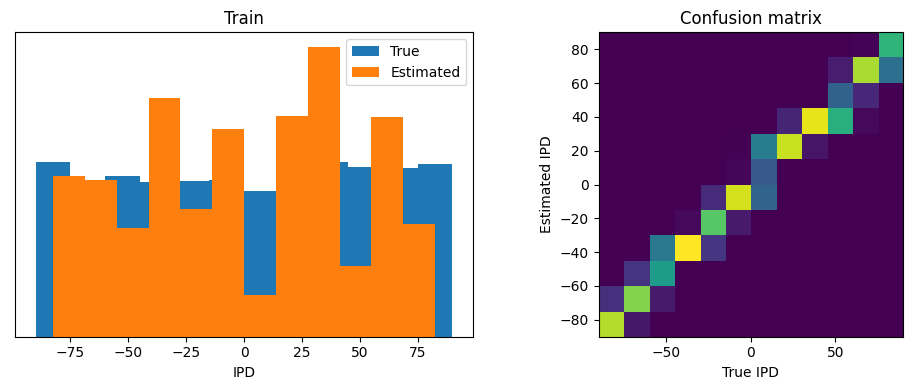

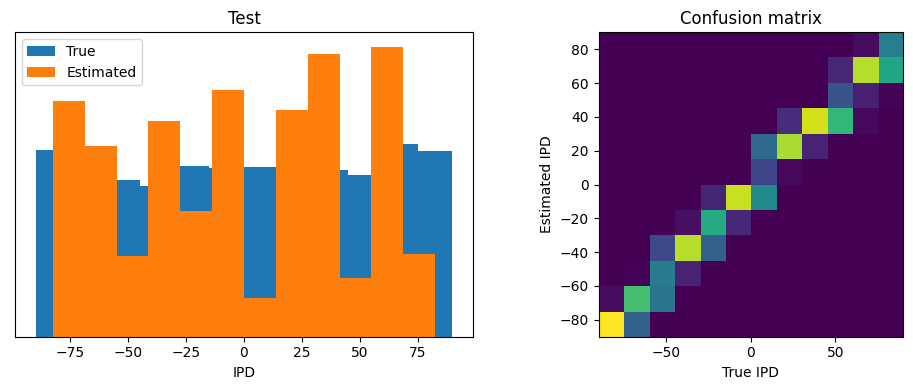

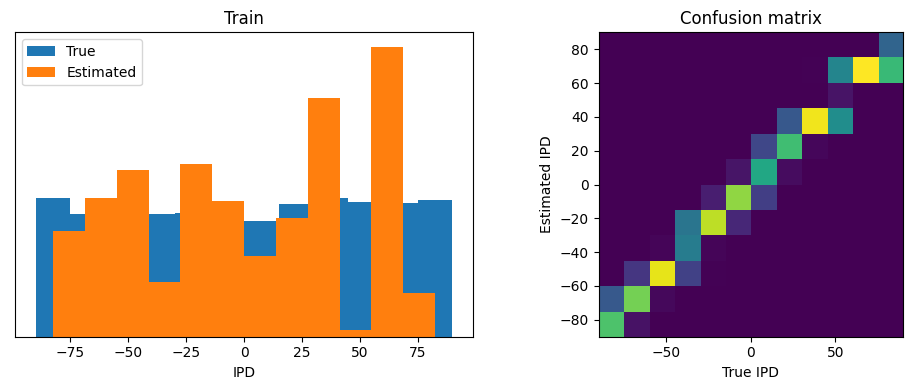

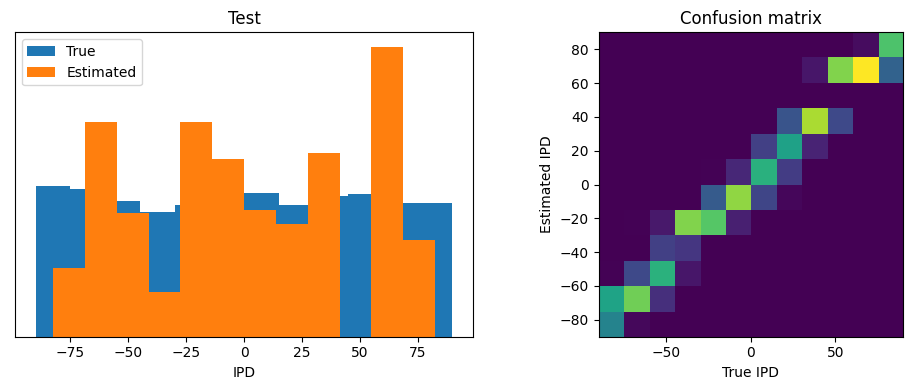

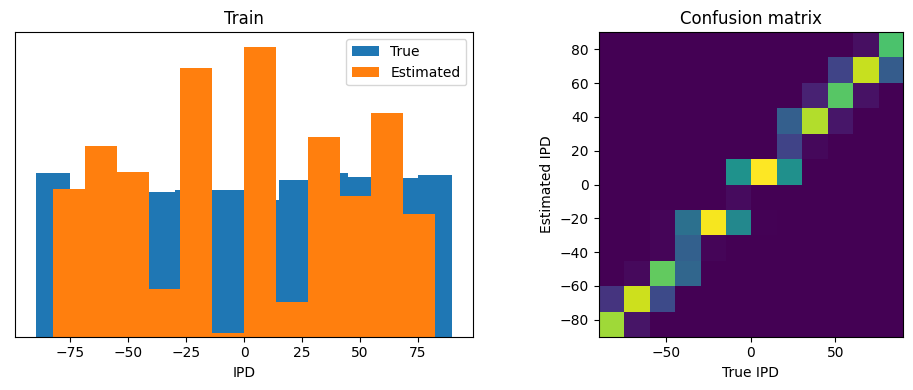

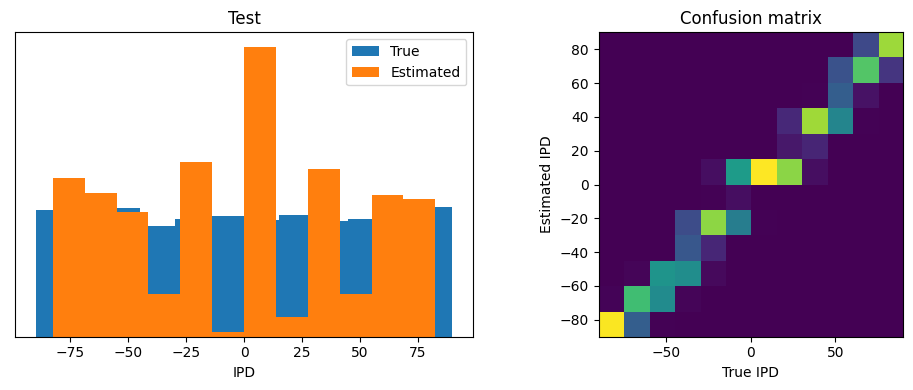

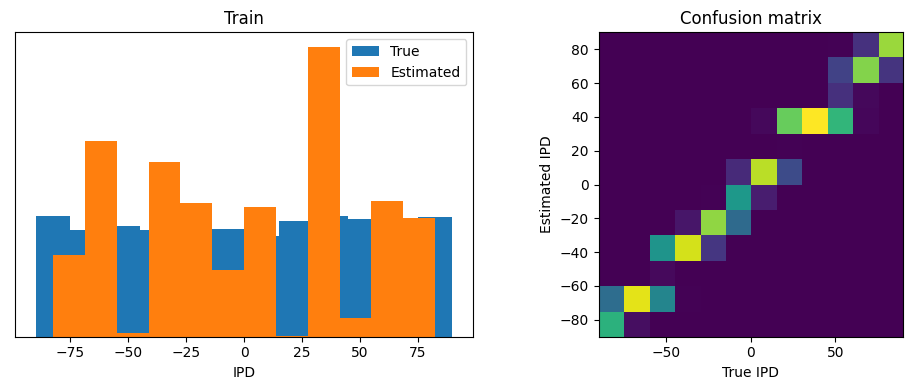

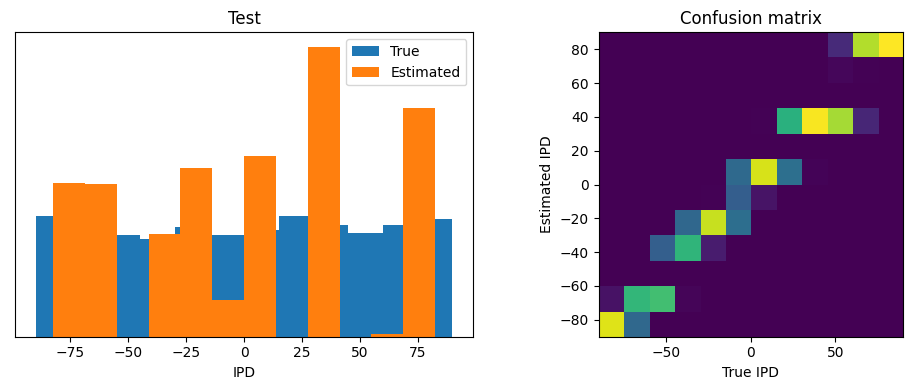

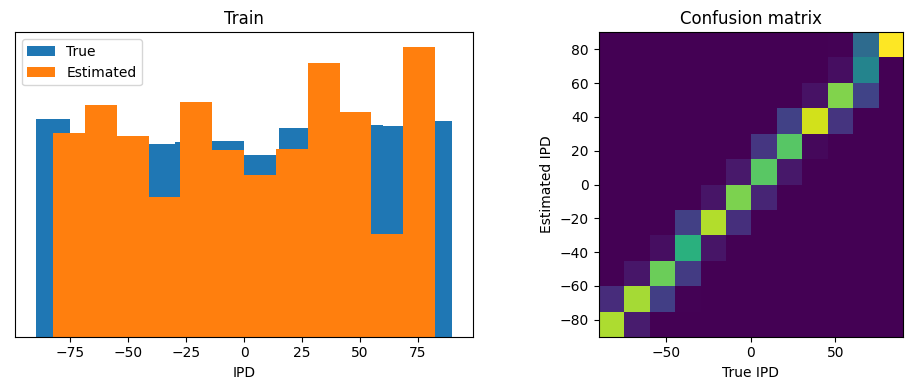

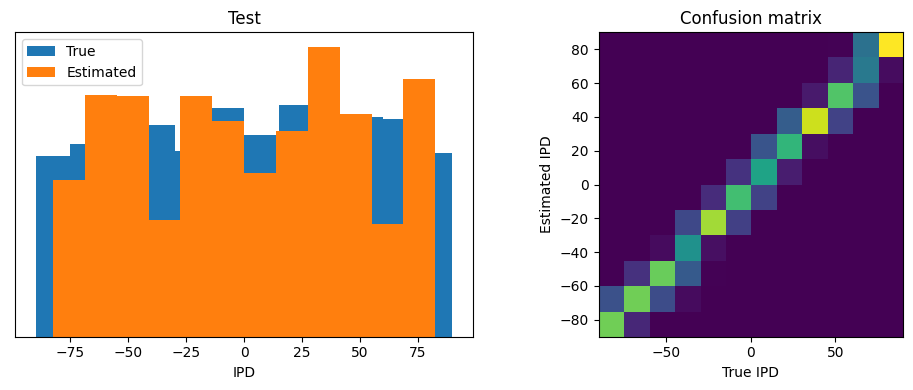

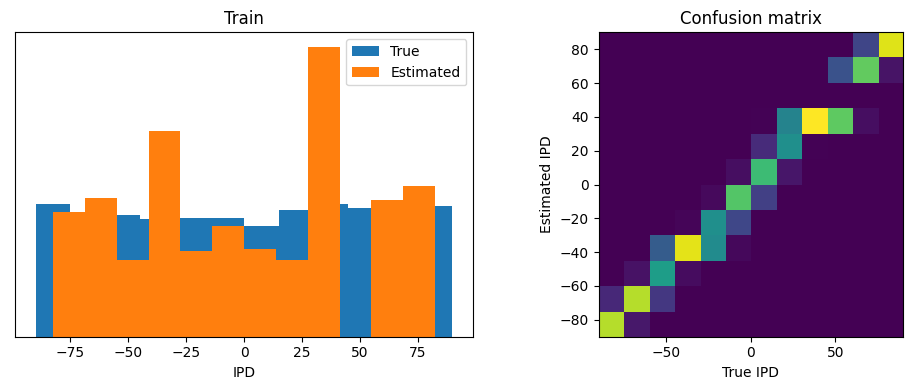

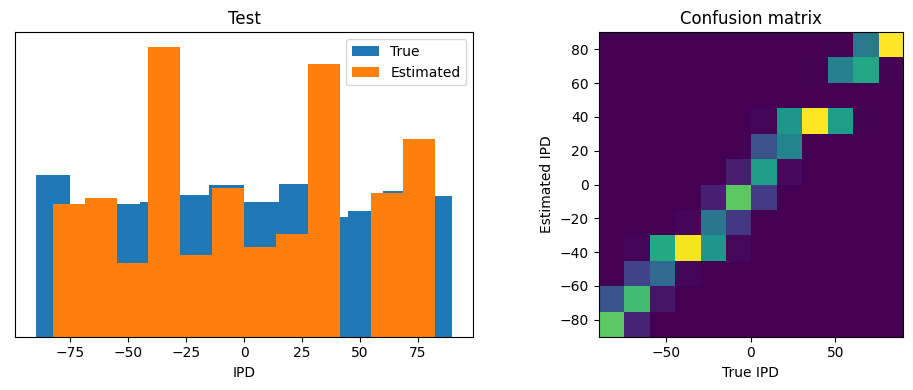

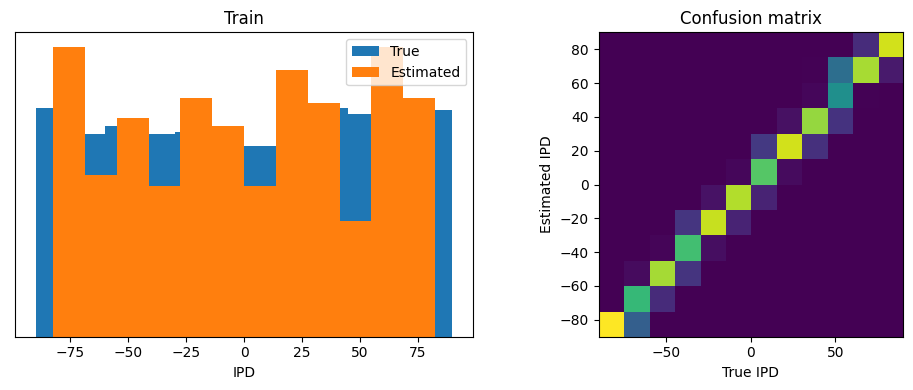

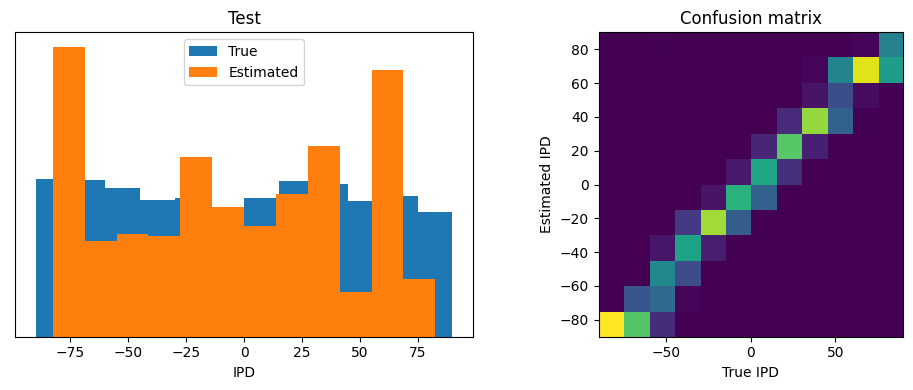

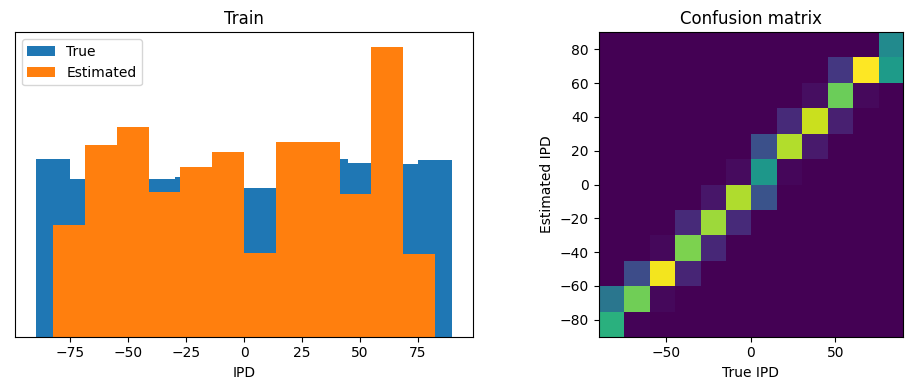

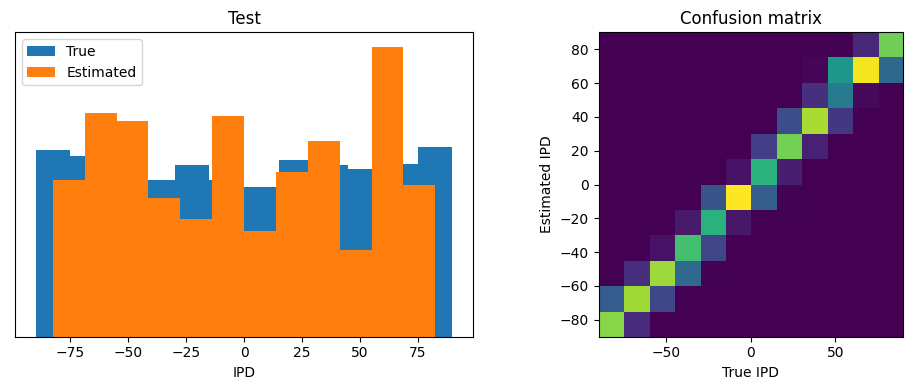

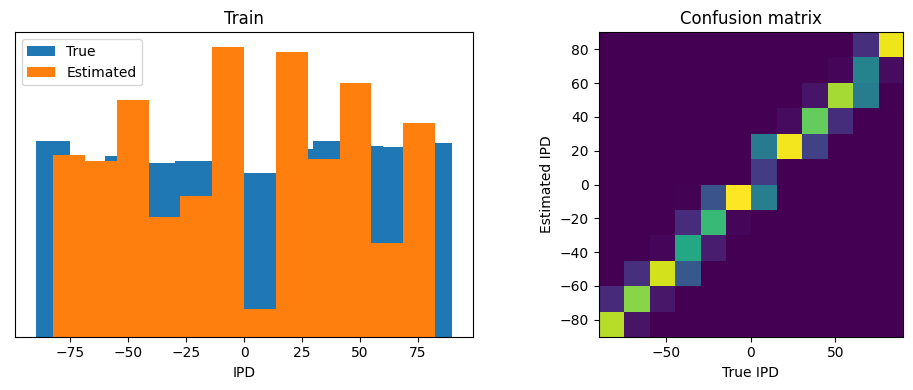

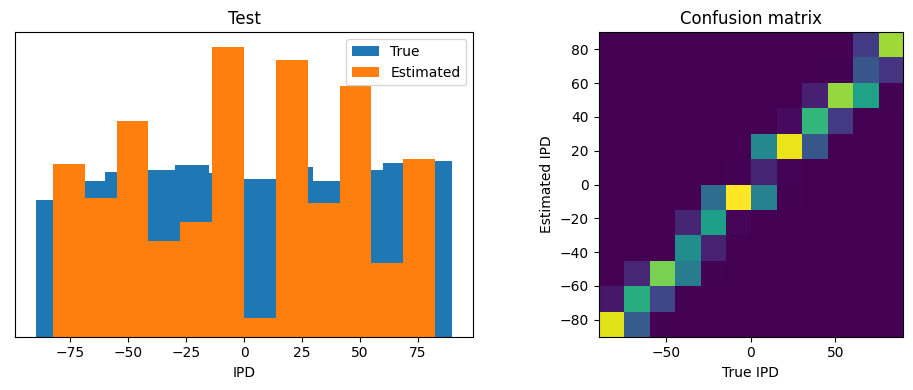

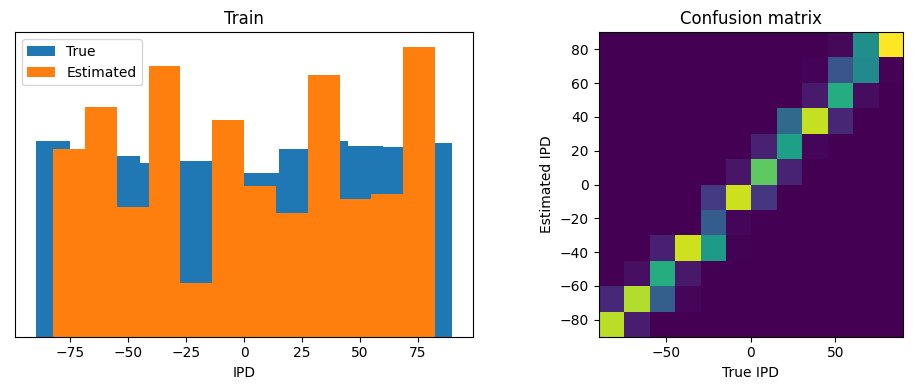

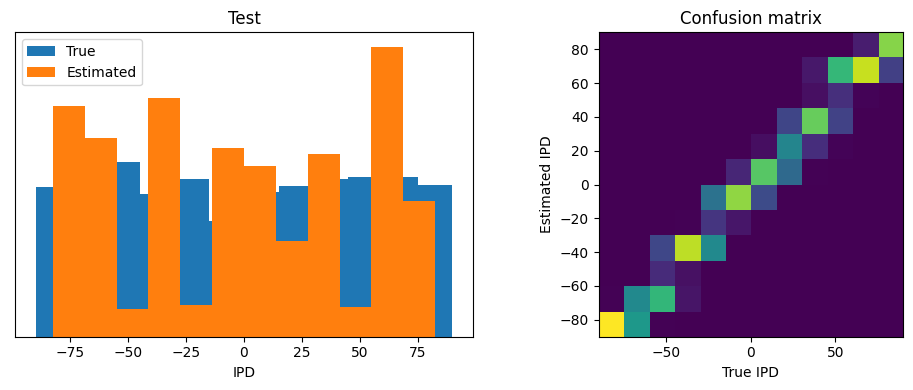

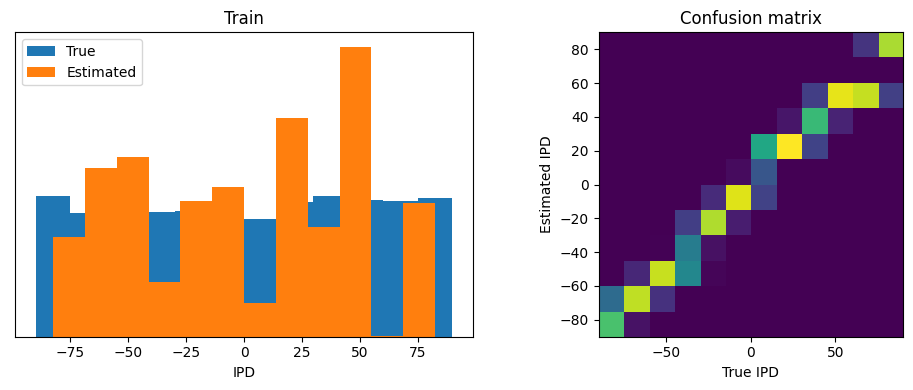

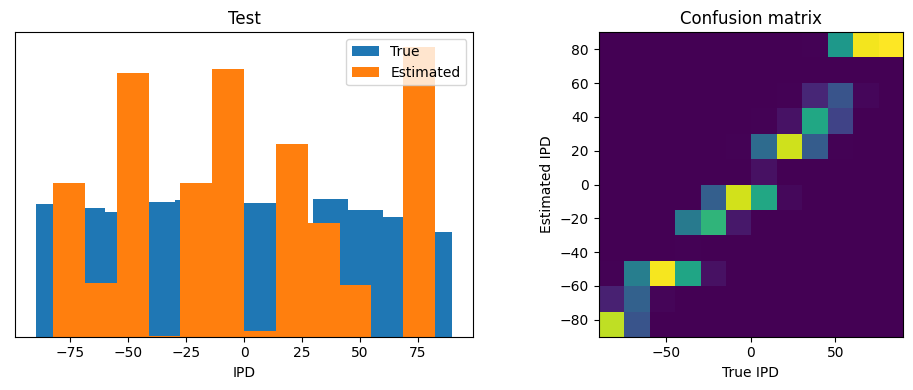

In [ ]:
# Generate the training data
ipds_training, spikes_training = random_ipd_input_signal(num_samples)
ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)

train_loss = np.zeros(11)
test_loss = np.zeros(11)

for i in range(11):
    w1, w2, signs = init_weight_matrices(inhib_chance = i*0.1)
    w1_trained, w2_trained, signs = train(ipds_training, spikes_training, ipds_validation, spikes_validation)

    run_func = lambda x: snn(x, w1_trained, w2_trained, signs)
    train_loss[i] = analyse_accuracy(ipds_training, spikes_training, run_func, 'Train')

    ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
    test_loss[i] = analyse_accuracy(ipds_test, spikes_test, run_func, 'Test')

In [ ]:
train_loss

array([72.92480469, 68.82324219, 68.99414062, 63.28125   , 79.27246094,
       69.77539062, 82.00683594, 77.44140625, 75.85449219, 73.4375    ,
       67.3828125 ])

In [ ]:
test_loss

array([66.55273438, 59.71679688, 59.47265625, 54.19921875, 69.28710938,
       62.3046875 , 63.8671875 , 70.21484375, 66.35742188, 59.03320312,
       54.83398438])

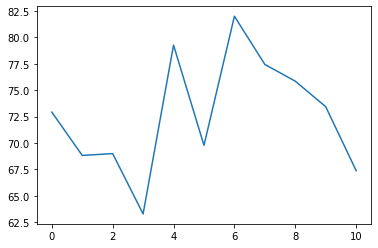

In [ ]:
plt.plot(train_loss)
plt.show()

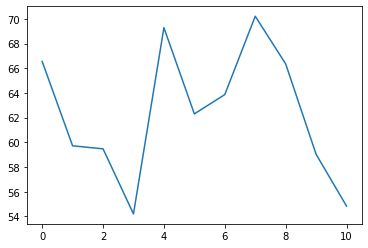

In [ ]:
plt.plot(test_loss)
plt.show()

## Future work
- Run multiple times/train longer
- Initialization and updates according to literature
- Try different activation functions
- Train the sign matrix
- Compare the weight matrices for each case
- Analyze the the spikes in the layers
- Stochastic/baseline firing

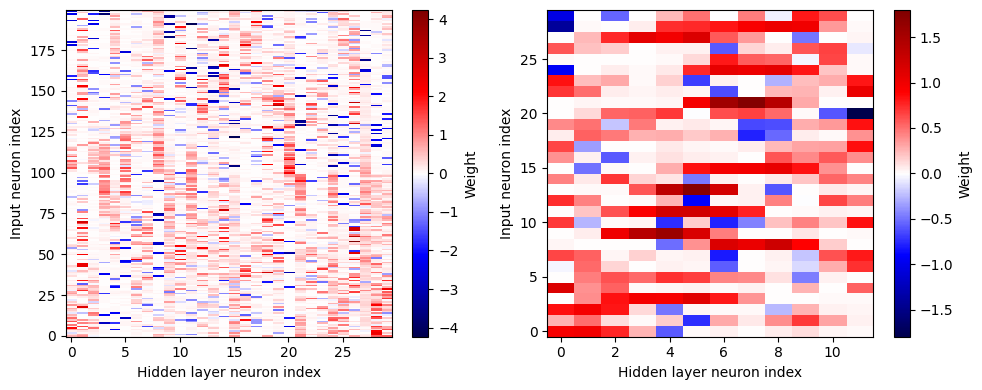

In [ ]:
def plot_single_weight_mat(ax, w):
    vmax = np.max(np.abs(w))
    im = ax.imshow(w, interpolation='nearest', aspect='auto', origin='lower', vmin=-vmax, vmax=vmax, cmap='seismic')
    ax.set_ylabel('Input neuron index')
    ax.set_xlabel('Hidden layer neuron index')
    ax.figure.colorbar(im, label="Weight", ax=ax)


def plot_weight_mats(w1, w2):
    plt.figure(figsize=(10, 4), dpi=100)
    ax = plt.subplot(121)
    plot_single_weight_mat(ax, w1.detach().cpu().numpy())

    ax = plt.subplot(122)
    plot_single_weight_mat(ax, w2.detach().cpu().numpy())

    plt.tight_layout()
    

plot_weight_mats(w1_trained, w2_trained)

In [ ]:
(w2_trained < 0).float().mean()

tensor(0.1139)

In [ ]:
def init_weight_matrices():
    """Weights and uniform weight initialisation"""

    # Input to hidden layer
    w1 = nn.Parameter(torch.empty((INPUT_SIZE, NUM_HIDDEN), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w1)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w1, -bound, bound)

    # Hidden layer to output
    w2 = nn.Parameter(torch.empty((NUM_HIDDEN, NUM_CLASSES), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w2)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(w2, -bound, bound)

    #Get fixed signs for the weight, 90% excitatory 
    signs = [(torch.rand_like(w) > 0.1).float() for w in (w1, w2)]
    
    for s in signs : 
      s[s == 0] = -1
      s.requires_grad=False

    return w1, w2, signs


In [ ]:
def train(ipds, spikes, ipds_validation, spikes_validation, lr=0.01):
    """
    :param lr: learning rate
    :return:
    """
    # Initialise a weight matrices
    w1, w2, signs = init_weight_matrices()

    ####################### MISSING CODE BELOW ########################
    # You need to learn parameters for two matrices
    # Optimiser and loss function
    optimizer = torch.optim.Adam([w1, w2], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()

    print(f"Want loss for epoch 1 to be about {-np.log(1 / NUM_CLASSES):.2f}, multiply m by constant to get this")

    loss_hist = []
    val_loss_hist = []

    best_loss = 1e10
    val_loss_best_loss = 1e10

    for e in pbar(range(N_EPOCHS)):
        local_loss = []
        for x_local, y_local in data_generator(discretise(ipds), spikes):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            #reg = torch.abs(torch.clamp(torch.min(W1), -np.inf, 0)) * 100
            reg = 0

            loss = loss_fn(log_softmax_fn(m), y_local) + reg
            local_loss.append(loss.item())

            # Update gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_hist.append(np.mean(local_loss))

        val_local_loss = []
        for x_local, y_local in data_generator(discretise(ipds_validation), spikes_validation):
            # Run network
            output = snn(x_local, w1, w2, signs)
            # Compute cross entropy loss
            m = torch.sum(output, 1)*0.01  # Sum time dimension

            val_loss = loss_fn(log_softmax_fn(m), y_local) 
            val_local_loss.append(val_loss.item())

        val_loss_hist.append(np.mean(val_local_loss))

        if np.mean(val_local_loss) < val_loss_best_loss:
            val_loss_best_loss = np.mean(val_local_loss)
            best_weights = get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs


        # noinspection PyStringFormat
        print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))
        print("Epoch %i: val_loss=%.5f"%(e+1, np.mean(val_local_loss)))

        #Early Stopping : 
        if torch.tensor(val_loss_hist[-5:]).argmin() == 0  and e>5: 
          print('Early Stop !')
          return best_weights

    # Plot the loss function over time
    plt.plot(loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    plt.plot(val_loss_hist)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tight_layout()

    return get_signed_weights(w1, signs[0]), get_signed_weights(w2, signs[1]), signs

# Generate the training data
ipds_training, spikes_training = random_ipd_input_signal(num_samples)
ipds_validation, spikes_validation = random_ipd_input_signal(num_samples)


w1_trained, w2_trained, signs = train(ipds_training, spikes_training, ipds_validation, spikes_validation)



In [ ]:
# Analyse
print(f"Chance accuracy level: {100 * 1 / NUM_CLASSES:.1f}%")
run_func = lambda x: snn(x, w1_trained, w2_trained, signs)
analyse_accuracy(ipds_training, spikes_training, run_func, 'Train')

ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse_accuracy(ipds_test, spikes_test, run_func, 'Test')

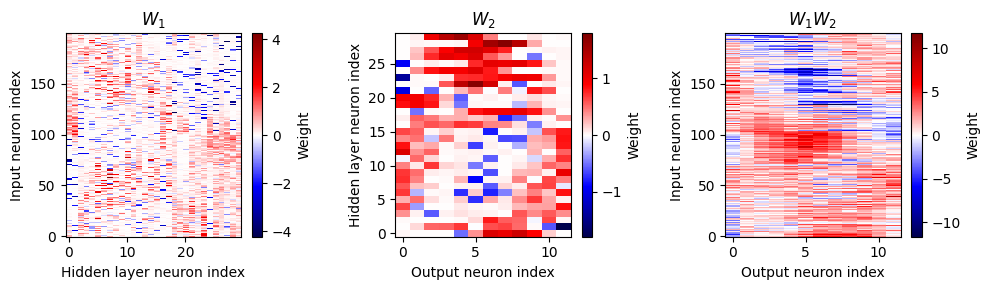

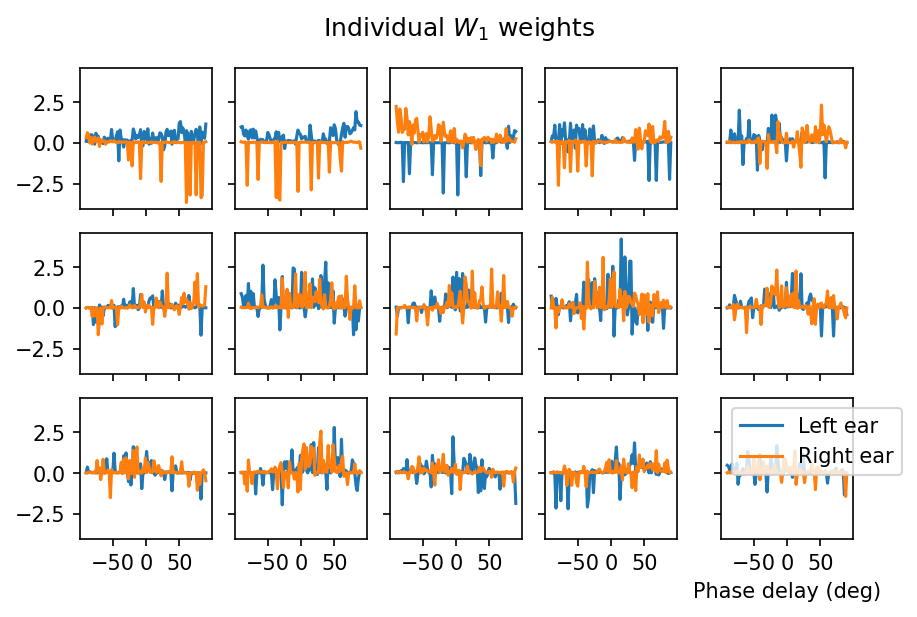

In [ ]:
def plot_weight_mats_sorted(w1, w2):
    w1 = w1.detach().cpu().numpy()
    w2 = w2.detach().cpu().numpy()

    # for each column of w1, compute the weighted mean and re-order according to that
    #A = np.arange(w1.shape[0])[:, None]
    A = np.hstack([np.arange(ANF_PER_EAR), -np.arange(ANF_PER_EAR)])[:, None]
    weighted_mean = np.mean((A*w1), axis=0)
    weighted_mean[np.max(w1, axis=0)<.5] = np.inf
    I = np.argsort(weighted_mean)
    w1 = w1[:, I]
    w2 = w2[I, :]

    # Plot the re-ordered weight matrices
    plt.figure(figsize=(10, 3), dpi=100)
    ax = plt.subplot(131)
    plot_single_weight_mat(ax, w1)
    ax.set_ylabel('Input neuron index')
    ax.set_xlabel('Hidden layer neuron index')
    ax.set_title('$W_1$')

    ax = plt.subplot(132)
    plot_single_weight_mat(ax, w2)
    ax.set_ylabel('Hidden layer neuron index')
    ax.set_xlabel('Output neuron index')
    ax.set_title('$W_2$')

    ax = plt.subplot(133)
    plot_single_weight_mat(ax, w1@w2)
    ax.set_ylabel('Input neuron index')
    ax.set_xlabel('Output neuron index')
    ax.set_title('$W_1W_2$')

    plt.tight_layout()

    # Plot some sample weights for hidden neurons

    big_weights = np.max(np.abs(w1), axis=0) > .5

    to_show_count = 15

    best_idcs = np.argsort(big_weights)[::-1][:to_show_count]


    fig, axs = plt.subplots(ncols=5, nrows=to_show_count // 5, dpi=150, sharex='all', sharey='all', constrained_layout=True)

    phi = np.linspace(-np.pi/2, np.pi/2, w1.shape[0]//2)

    for i, j in enumerate(best_idcs):

        ax = axs.ravel()[i]

        ax.plot(phi*180/np.pi, w1[:w1.shape[0]//2, j], label="Left ear")

        ax.plot(phi*180/np.pi, w1[w1.shape[0]//2:, j], label="Right ear")

    plt.suptitle("Individual $W_1$ weights")
    plt.legend(loc='best')
    plt.xlabel('Phase delay (deg)')

plot_weight_mats_sorted(w1_trained, w2_trained)

Note a diagonal trend in W1 as well single contiguous bumps in columns of W2, suggesting a preference for coincidence detection.  However the accuracy gets much worse (50% on test).

In [ ]:
def plot_traces(ax, traces):
    cmap = matplotlib.cm.get_cmap('hsv')
    norm = matplotlib.colors.Normalize(vmin=-180, vmax=+180)

    c = continuise(np.arange(traces.shape[0])) * 180/np.pi
    totals = np.sum(traces, axis=1)
    z_sorting = np.argsort(totals)[::1]
    

    for j in z_sorting:
        trace = traces[j]
        color = cmap(norm(c[j]))
        ax.plot(trace, color=color)
    
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(c)
    ax.figure.colorbar(sm, ax=ax, label='ipd')


def plot_single_run(angle, example_input, s_rec, v_rec):
    f, axs = plt.subplots(nrows=4, sharex='all', figsize=(4, 4), dpi=150, constrained_layout=True)
    
    f.suptitle(f'true angle: {angle*180/np.pi}')

    ax = axs[0]
    ax.imshow(example_input.T, aspect='auto', interpolation='nearest', origin='lower', cmap=plt.cm.gray_r)
    ax.set(
        ylabel='uV',
        title='spikes input neurons',
    )

    ax = axs[1]
    ax.imshow(s_rec.T, aspect='auto', interpolation='nearest', origin='lower', cmap=plt.cm.gray_r)
    ax.set(
        ylabel='uV',
        title='spikes hidden neurons',
    )

    ax = axs[2]
    plot_traces(ax, v_rec.T)
    ax.set(
        ylabel='uV',
        title='mem. output neurons',
    )

    ax = axs[3]
    plot_traces(ax, np.cumsum(v_rec.T, axis=1))
    ax.set(
        xlabel='time',
        ylabel='uV',
        title='cum. mem. output neurons',
    )

def study_single_example(angle, w1, w2):
    example_input = spikes_from_fixed_idp_input_signal(np.array([angle]))

    tau = 2 * MS

    s_rec = layer1(example_input, w1, tau, signs[0])
    v_rec = layer2(s_rec, w2, tau)

    example_input = example_input[0]
    s_rec = s_rec.detach().numpy()[0]
    v_rec = v_rec.detach().numpy()[0]

    plot_single_run(angle, example_input, s_rec, v_rec)
    


study_single_example(np.pi * 0.5, w1_trained, w2_trained)

TypeError: ignored

Looking a bit at membrane traces of the output neurions, it seems like the decision is taken mostly in the trough of the sinusoid input, probably because in that period the FRs are low enough that coincidence is more significative for the discrimination.


## Further work
- Fix gradient of ABS at 0.
- Reduce firing rates of AFN. What are realistic values?
- Check out Blake Richards' work showing that you can train ANNs following Dale's law without loss of performance.